<a href="https://colab.research.google.com/github/zhihong1224/LHY_ML/blob/master/hw6_adversarial_attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [1]:
# 下載資料
!gdown --id '14CqX3OfY9aUbhGp4OpdSHLvq2321fUB7' --output data.zip
# 解壓縮
!unzip -qq -u data.zip
# 確認目前的檔案
!ls

Downloading...
From: https://drive.google.com/uc?id=14CqX3OfY9aUbhGp4OpdSHLvq2321fUB7
To: /content/data.zip
17.9MB [00:00, 57.0MB/s]
data  data.zip	sample_data


# FGSM

In [5]:
import os
import cv2
import pandas as pd
from PIL import Image
import numpy as np

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import Dataset,DataLoader

import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline

from imageio import imsave
import warnings
warnings.filterwarnings("ignore")

device=torch.device('cuda')

In [96]:
# 读取数据
class Adverdataset(Dataset):
  def __init__(self,root,label,transforms):
    self.root=root
    self.label=torch.from_numpy(label).long()
    self.transforms=transforms
    self.fnames=[]
    for i in range(200):
      self.fnames.append('{:03d}'.format(i))
  def __len__(self):
    return 200
  def __getitem__(self,idx):
    img=Image.open(os.path.join(self.root,self.fnames[idx]+'.png'))
    img=self.transforms(img)
    label=self.label[idx]
    return img,label

In [106]:
# 载入模型并进行FGSM攻击
class Attacker:
  def __init__(self,img_dir,out_root,label):
    self.model=models.resnet50(pretrained=True)
    self.model.cuda()
    self.model.eval()
    self.mean=[0.485,0.456,0.406]
    self.std=[0.229,0.224,0.225]
    self.normalize=transforms.Normalize(self.mean,self.std,inplace=False)
    transform=transforms.Compose([
      transforms.Resize((224,224),interpolation=3),
      transforms.ToTensor(),
      self.normalize
    ])
    self.dataset=Adverdataset('./data/images',label,transform)
    self.loader=torch.utils.data.DataLoader(
        self.dataset,
        batch_size=1,
        shuffle=False
    )
    self.out_root=out_root
  # FGSM攻击
  def fgsm_attack(self,image,epsilon,data_grad):
    sign_data_grad=data_grad.sign()
    perturbed_image=image+epsilon*sign_data_grad
    return perturbed_image
  def attack(self,epsilon):
    adv_examples=[]
    wrong,fail,success=0,0,0
    L_inf=0.
    for (data,target) in self.loader:
      data,target=data.to(device),target.to(device)
      data_raw=data
      data.requires_grad=True
      output=self.model(data)
      init_pred=output.max(1,keepdim=True)[1]

      if init_pred.item()!=target.item():
        wrong+=1
        continue

      loss=F.nll_loss(output,target)
      self.model.zero_grad()
      loss.backward()
      data_grad=data.grad.data
      perturbed_data=self.fgsm_attack(data,epsilon,data_grad)
      output=self.model(perturbed_data)
      final_pred=output.max(1,keepdim=True)[1]

      if final_pred.item()==target.item():
        fail+=1
      else:
        success+=1
        L_inf+=abs(perturbed_data-data_raw).max()

        adv_ex=perturbed_data.cpu()*torch.tensor(self.std).view(3,1,1)+torch.tensor(self.mean).view(3,1,1)
        adv_ex=adv_ex.squeeze().detach().numpy()
        save_img=(adv_ex.transpose(1,2,0)*255).astype('uint8')
        imsave(os.path.join(self.out_root,str(success-1).rjust(3,'0')+'.png'),save_img)
        print('save '+str(success)+' img')
        if len(adv_examples)<5:
          img_raw=data_raw.cpu()*torch.tensor(self.std).view(3,1,1)+torch.tensor(self.mean).view(3,1,1)
          img_raw=img_raw.squeeze().detach().numpy()
          adv_examples.append((init_pred.item(),final_pred.item(),img_raw,adv_ex))

    test_acc=success/float(len(self.loader))
    L_inf/=success
    print('Epsilon:{} | wrong:{} | success rate={}/{}={} | L_inf norm:{}\n'.format(epsilon,wrong,success,len(self.loader),test_acc,L_inf))
    return adv_examples,test_acc

In [ ]:
if __name__=='__main__':
  df=pd.read_csv('./data/labels.csv')
  df=df.loc[:,'TrueLabel'].to_numpy()
  label_name=pd.read_csv('./data/categories.csv')
  label_name=label_name.loc[:,'CategoryName'].to_numpy()
  attacker=Attacker('./data/images','./output',df)
  epsilons=[1]  # epsilon越大，对抗样本失真越严重
  accuracies,examples=[],[]

  for eps in epsilons:
    ex,acc=attacker.attack(eps)
    accuracies.append(acc)
    examples.append(ex)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


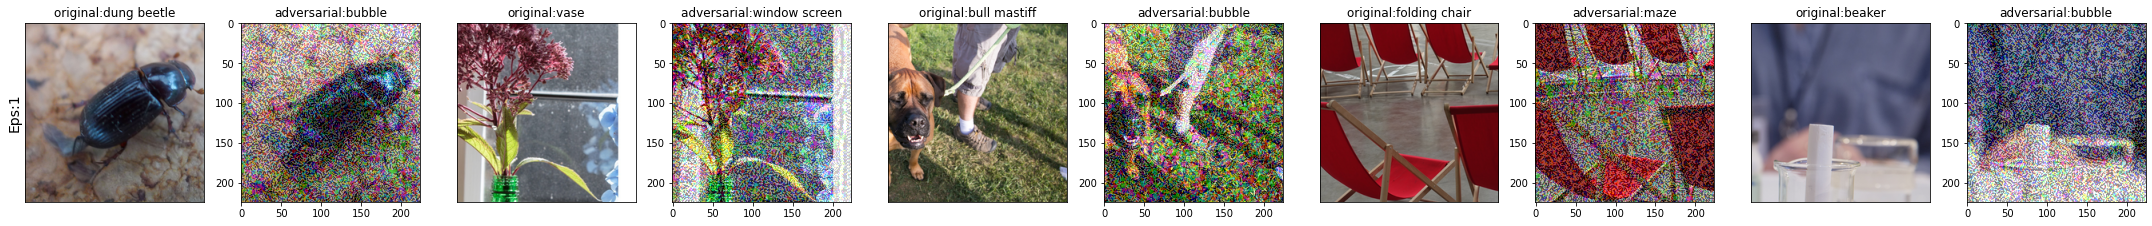

In [109]:
# 展示FGSM产生的图片
cnt=0
plt.figure(figsize=(30,30))

for i in range(len(epsilons)):
  for j in range(len(examples[i])):
    cnt+=1
    plt.subplot(len(epsilons),len(examples[0])*2,cnt)
    plt.xticks([],[])
    plt.yticks([],[])
    if j==0:
      plt.ylabel('Eps:{}'.format(epsilons[i]),fontsize=14)
    orig,adv,orig_img,ex=examples[i][j]
    plt.title('original:{}'.format(label_name[orig].split(',')[0]))
    orig_img=np.transpose(orig_img,(1,2,0))
    plt.imshow(orig_img)
    cnt+=1
    plt.subplot(len(epsilons),len(examples[0])*2,cnt)
    plt.title('adversarial:{}'.format(label_name[adv].split(',')[0]))
    ex=np.transpose(ex,(1,2,0))
    plt.imshow(ex)
plt.tight_layout()
plt.show()

# I-FGSM

In [3]:
class Adverdataset(Dataset):
  def __init__(self,in_root):
    self.img_root=os.path.join(in_root,'images')
    self.label_root=os.path.join(in_root,'labels.csv')
    self.label=torch.from_numpy(pd.read_csv(self.label_root).loc[:,'TrueLabel'].to_numpy()).long()
    self.transform=transforms.Compose([
      transforms.Resize((224,224),interpolation=3),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225],inplace=False)
    ])
  def __getitem__(self,item):
    img=Image.open(os.path.join(self.img_root,str(item).rjust(3,'0')+'.png'))
    return self.transform(img),self.label[item]
  def __len__(self):
    return len(self.label)

In [14]:
# 迭代FGSM算法：I-FGSM
class Attacker(object):
  def __init__(self,in_root,out_root,alpha,epsilon,model):
    dataset=Adverdataset(in_root)
    self.out_root=out_root
    self.loader=DataLoader(dataset,batch_size=1,shuffle=False)
    self.alpha=alpha
    self.epsilon=epsilon
    self.model=model.to(device)
    self.model.eval()
    self.mean=torch.tensor([0.485,0.456,0.406])
    self.std=torch.tensor([0.229,0.224,0.225])
  def clip(self,delta,img):
    delta.clamp_(-self.epsilon,self.epsilon)
    temp=img+delta
    perturbed_img=temp.clamp(0,255)
    return perturbed_img

  # 无目标的攻击
  def where(self,cond,x,y):
    cond=cond.float()
    return (cond*x)+((1-cond)*y)
  def attack(self,target,defend=False,iterations=10):
    adv_examples=[]
    output_examples=[]
    wrong,fail,success,after_success=0,0,0,0
    L_inf=0.
    for (img,label) in self.loader:
      img,label=img.to(device),label.to(device)
      img_raw=img   # 保存原图像

      perturbed_img=Variable(img.data,requires_grad=True)
      output_org=self.model(img)
      output_org=torch.softmax(output_org,dim=1)
      init_pred=output_org.argmax(dim=1)
      if init_pred.item()!=label.item():
        wrong+=1
        continue

      for i in range(iterations):
        output_adv=self.model(perturbed_img)
        output_adv=torch.softmax(output_adv,dim=1)
        if target:
          tar=output_org.argmin(dim=1)
          loss=-F.nll_loss(output_adv,tar)
        else:
          loss=F.nll_loss(output_adv,label)
        self.model.zero_grad()
        loss.backward()
       
        # 更新一步
        perturbed_img=perturbed_img+self.alpha*perturbed_img.grad.sign()
        # 截断
        perturbed_img=torch.clamp(perturbed_img,0.,1.)
        perturbed_img=self.where(perturbed_img>img_raw+self.epsilon,img_raw+self.epsilon,perturbed_img)
        perturbed_img=self.where(perturbed_img<img_raw-self.epsilon,img_raw-self.epsilon,perturbed_img)
        
        perturbed_img=Variable(perturbed_img.data,requires_grad=True)
        
      output_adv=self.model(perturbed_img)
      output_adv=torch.softmax(output_adv,dim=1)
      final_pred=output_adv.argmax(dim=1)
      if final_pred.item()==label.item():
        fail+=1
      else:
        success+=1
        L_inf+=abs(perturbed_img-img_raw).max()
        # 保存对抗样本
        adv_ex=perturbed_img.cpu()*self.std.view(3,1,1)+self.mean.view(3,1,1)
        adv_ex=adv_ex.squeeze().detach().numpy()
        save_img=(adv_ex.transpose(1,2,0)*255).astype('uint8')
        imsave(os.path.join(self.out_root,str(success-1).rjust(3,'0')+'.png'),save_img)
        print('save '+str(success)+' img')
        # 保存显示图像
        if len(adv_examples)<5:
          img_raw=img_raw.cpu()*self.std.view(3,1,1)+self.mean.view(3,1,1)
          img_raw=img_raw.squeeze().detach().numpy()
          adv_examples.append((init_pred.item(),final_pred.item(),img_raw,adv_ex))
          output_examples.append((output_org,output_adv))

    L_inf=L_inf/success
    success_rate=success/float(len(self.loader))
    print('epsilon:{} | wrong:{} | success rate:{}/{}={} | L-inf norm:{}'.format(self.epsilon,wrong,
                                                                      success,len(self.loader),success_rate,L_inf))
    return adv_examples,success_rate,output_examples


In [ ]:
if __name__=='__main__':
  in_root='./data'
  out_root='./output'
  alpha=0.1
  epsilons=[1]
  model=models.resnet50(pretrained=True)
  accuracies,examples,output_examples=[],[],[]
  label_name=pd.read_csv(os.path.join(in_root,'categories.csv'))
  label_name=label_name.loc[:,'CategoryName'].to_numpy()

  for eps in epsilons:
    attacker=Attacker(in_root,out_root,alpha,eps,model)
    ex,acc,out_ex=attacker.attack(target=False,defend=False)
    accuracies.append(acc)
    examples.append(ex)
    output_examples.append(out_ex)

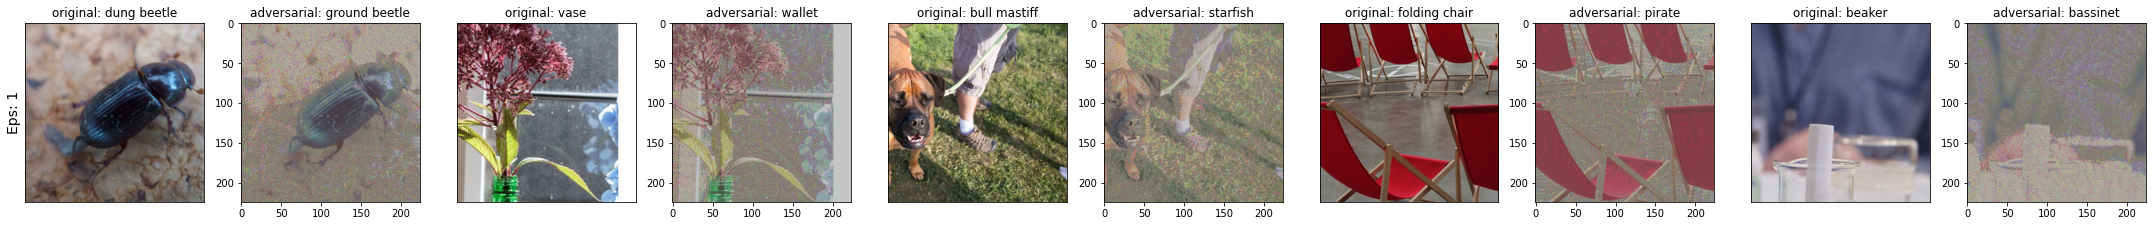

In [16]:
cnt = 0
plt.figure(figsize=(30, 30))
for i in range(len(epsilons)):
    for j in range(5):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]) * 2,cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,orig_img, ex = examples[i][j]
        # plt.title("{} -> {}".format(orig, adv))
        plt.title("original: {}".format(label_name[orig].split(',')[0]))
        orig_img = np.transpose(orig_img, (1, 2, 0))
        plt.imshow(orig_img)
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]) * 2,cnt)
        plt.title("adversarial: {}".format(label_name[adv].split(',')[0]))
        ex = np.transpose(ex, (1, 2, 0))
        plt.imshow(ex)
plt.tight_layout()
plt.show()

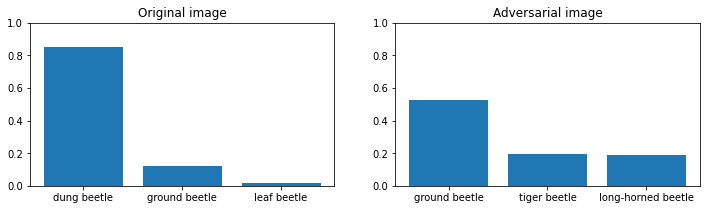

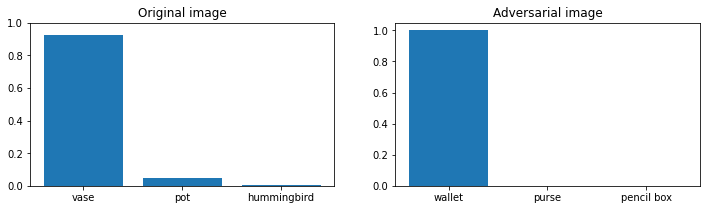

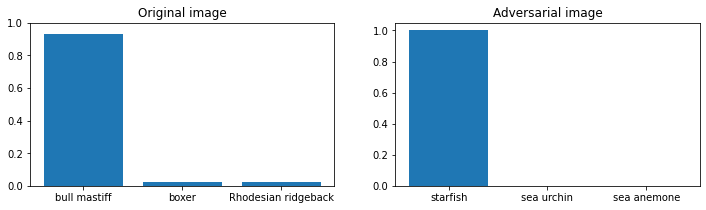

In [10]:
# 绘制三张图像攻击前后的机率图(分别取前三高的机率)
for i in range(3):
  plt.figure(figsize=(12,3))
  out_org,out_adv=output_examples[0][i]
  top3_org=torch.topk(out_org,3,dim=1)[0].tolist()[0]
  top3_adv=torch.topk(out_adv,3,dim=1)[0].tolist()[0]
  idx_org=torch.topk(out_org,3)[1].tolist()[0]
  idx_adv=torch.topk(out_adv,3)[1].tolist()[0]
  index_org=[label_name[idx].split(',')[0] for idx in idx_org]
  index_adv=[label_name[idx].split(',')[0] for idx in idx_adv]
  
  plt.subplot(1,2,1)
  p1=plt.bar(range(3),top3_org,tick_label=index_org)
  plt.title('Original image')
  plt.yticks(np.arange(0,1.2,0.2))
  plt.subplot(1,2,2)
  p2=plt.bar(range(3),top3_adv,tick_label=index_adv)
  plt.title('Adversarial image')
  plt.yticks(np.arange(0,1.2,0.2))

# 被动防御

In [11]:
# 被动防御
class Defdataset(Dataset):
  def __init__(self,scr_root,def_root,mode,filter_size,defend=True):
    self.scr_root=os.path.join(scr_root,'images')
    self.def_root=def_root
    self.label_root=os.path.join(scr_root,'labels.csv')
    self.label=torch.from_numpy(pd.read_csv(self.label_root).loc[:,'TrueLabel'].to_numpy()).long()
    self.trans=[]
    if mode=='gaussian':
      self.trans.append(transforms.Lambda(lambda img:cv2.GaussianBlur(img,(filter_size,filter_size),0)))
    elif mode=='median':
      self.trans.append(transforms.Lambda(lambda img:cv2.medianBlur(img,filter_size)))
    elif mode=='bilateral':
      self.trans.append(transforms.Lambda(lambda img:cv2.bilateralFilter(img,5,300,300)))
    self.trans.append(transforms.ToTensor())
    self.trans.append(transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225],inplace=False))
    self.transform=transforms.Compose(self.trans)
    self.defend=defend
  def __getitem__(self,item):
    if self.defend:
      img=np.array(Image.open(os.path.join(self.def_root,str(item).rjust(3,'0')+'.png')))
    else:
      img=np.array(Image.open(os.path.join(self.scr_root,str(item).rjust(3,'0')+'.png')))
    return self.transform(img),self.label[item]
  def __len__(self):
    return len(self.label)

In [13]:
defdataset=Defdataset('./data','./output',mode='median',filter_size=5,defend=True)
defloader=DataLoader(defdataset,batch_size=12,shuffle=False)

scrdataset=Defdataset('./data','./output',mode='median',filter_size=5,defend=False)
scrloader=DataLoader(scrdataset,batch_size=12,shuffle=False)

model=models.resnet50(pretrained=True)

model=model.to(device)
model.eval()

# 防御后仍然攻击成功
success,acc=0,0
with torch.no_grad():
  for data,label in defloader:
    data,label=data.to(device),label.to(device)
    pred=model(data)
    success+=(pred.argmax(dim=1)!=label).sum().item()

  for data,label in scrloader:
    data,label=data.to(device),label.to(device)
    pred=model(data)
    acc+=(pred.argmax(dim=1)==label).sum().item()

success_rate=success/float(len(defdataset))

accuracy=acc/float(len(scrdataset))

print('accuracy:{} | success rate:{}'.format(accuracy,success_rate))

accuracy:0.665 | success rate:0.905
